In [1]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [2]:
try:
    import numpy as np
    print("successfully imported numpy")
    print(np.__version__)
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy
1.26.4


In [3]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [4]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 1.2.7
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, dscribe
Required-by: 


In [77]:
import os, sys, site
sys.path.append(site.USER_SITE)

import aenet_gpr
print(aenet_gpr.__version__)

from aenet_gpr.util import ReferenceData, standard_output, inverse_standard_output
from aenet_gpr.src import gpr_batch
from aenet_gpr.inout import io_train_parameters, io_test_parameters

1.2.7


# 1. Read reference training/test data from xsf files

We are using train/test data of H-H Lennard-Jones potential prepared in `aenet-gpr/example/1_H2/`

In [7]:
import os.path

! rm -rf 1_H2
! mkdir 1_H2

if os.path.isfile("../example/1_H2/train_set.zip"):
    ! unzip -oq ../example/1_H2/train_set.zip -d ./1_H2/
    print("number of train data:")
    ! find ./1_H2/train_set/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/train_set.zip
    ! unzip -oq train_set.zip -d ./1_H2/
    ! rm train_set.zip
    print("number of train data:")
    ! find ./1_H2/train_set/ -type f | wc -l

--2025-05-18 15:30:12--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/train_set.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/train_set.zip [following]
--2025-05-18 15:30:12--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/train_set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4676 (4.6K) [application/zip]
Saving to: ‘train_set.zip’

train_set.zip       100%[===================>]   4.57K  --.-KB/s    in 0s      

2025-05-18 15:30:13 (16.8 MB/s) - ‘train_set.zip’ 

In [9]:
if os.path.isfile("../example/1_H2/test_set.zip"):
    ! unzip -oq ../example/1_H2/test_set.zip -d ./1_H2/
    print("number of test data:")
    ! find ./1_H2/test_set/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/test_set.zip
    ! unzip -oq test_set.zip -d ./1_H2/
    ! rm test_set.zip
    print("number of test data:")
    ! find ./1_H2/test_set/ -type f | wc -l

--2025-05-18 15:31:08--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/test_set.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/test_set.zip [following]
--2025-05-18 15:31:09--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/test_set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122489 (120K) [application/zip]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>] 119.62K  --.-KB/s    in 0.003s  

2025-05-18 15:31:09 (36.4 MB/s) - ‘test_set.zip’ sav

First, let aenet-gpr read the train/test files

In [10]:
import glob


train_xsf_files = glob.glob("./1_H2/train_set/file_*")
train_xsf_files.sort()
train_data = ReferenceData(structure_files=train_xsf_files, file_format='xsf')
train_data.set_data()

print(train_data.energy.shape)
print(train_data.force.shape)

(7,)
(7, 2, 3)


In [11]:
test_xsf_files = glob.glob("./1_H2/test_set/file_*")
test_xsf_files.sort()
test_data = ReferenceData(structure_files=test_xsf_files, file_format='xsf')
test_data.set_data()

print(test_data.energy.shape)
print(test_data.force.shape)

(200,)
(200, 2, 3)


# 2. Model train

Second, construct a GPR model fitted to training energy and force data (7 sample points). 

In this example, default settings, energy/force standardization and sqexp kernel parameters, are used.

In [12]:
if train_data.standardization:
    train_data.standardize_energy_force(train_data.energy)
train_data.config_calculator()

io_train_parameters(data_param=train_data.write_params())


Training parameters
{'num_data': 7, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



# 3. Model evaluation for test set

Finally, using the constructed GPR model, evaluate energy and force of test structures (200 structures).

In [13]:
test_data.calculator = train_data.calculator

io_test_parameters(data_param=test_data.write_params())

energy_test_gpr, force_test_gpr, uncertainty_test_gpr = test_data.evaluation(get_variance=True)


Test parameters
{'num_data': 200, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



Since the training energy/force values were standardized, the raw predictions should also be standardized.

Final predictions on energy and force can be obtained from inverse standardization.

In [14]:
if train_data.standardization:
    energy_test_gpr, force_test_gpr = inverse_standard_output(energy_ref=train_data.energy,
                                                              scaled_energy_target=energy_test_gpr,
                                                              scaled_force_target=force_test_gpr)

abs_force_test_gpr = np.linalg.norm(force_test_gpr, axis=2)
abs_force_test = np.linalg.norm(test_data.force, axis=2)

print("Energy MAE (eV):", np.absolute(np.subtract(energy_test_gpr, test_data.energy)).mean())
print("Force MAE (eV/Ang):", np.absolute(np.subtract(abs_force_test_gpr, abs_force_test)).mean())

Energy MAE (eV): 0.0028030539985482304
Force MAE (eV/Ang): 0.10320611715059153


# 4. Visualize the results

Now, let's compare the GPR predictions with the target Lennard-Jones potential.

The results will be shown by energy/force vs H-H bond distance plots.

In [15]:
d_train = []
for image in train_data.images:
    d_train.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

d_test = []
for image in test_data.images:
    d_test.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

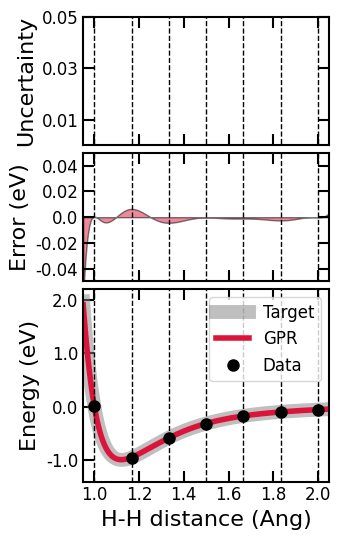

In [16]:
fig = plt.figure(figsize=(3.5, 5.5))
ax1, ax2, ax3 = fig.subplots(3, 1, height_ratios=[1, 1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'} 


# The 1st plot
ax1.fill_between(d_test, uncertainty_test_gpr, 0, label='Uncertainty', color='crimson', alpha=0.5, edgecolor='black')
ax1.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

# ax1.set_xlabel("Error in energy [eV]", fontdict=font_x)
ax1.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax1.get_xticks()]
ax1.set_xticks(x_labels)
ax1.set_xlim([0.95, 2.05])
ax1.set_xticklabels(x_labels, fontdict=font_tick)

ax1.set_ylabel('Uncertainty', fontdict=font_y)
ax1.set_ylim(0, 0.05)
y_labels = [round(label, 3) for label in ax1.get_yticks()]
y_labels = [0.01, 0.03, 0.05]
ax1.set_yticks(y_labels)
ax1.set_ylim([0, 0.05])
ax1.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax1.spines.values()]
ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.tick_params(direction='in', length=8, width=1.5)


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_gpr, test_data.energy), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_gpr, '-', label='GPR', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Data', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

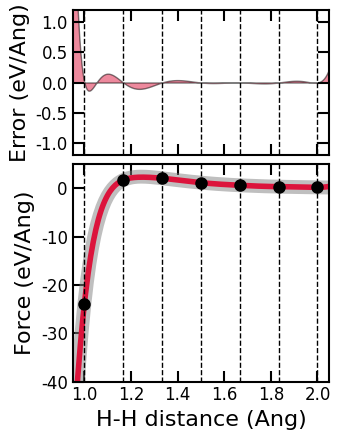

In [17]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_gpr[:, 0, 0], test_data.force[:, 0, 0]), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV/Ang)", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_gpr[:, 0, 0], '-', label='GPR', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force (eV/Ang)', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

# ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()

# 5. Generate additional data

In [28]:
import copy
from aenet_gpr.util import AdditionalData

In [29]:
additional_data = AdditionalData(reference_training_data=train_data)
disp = np.array([[0.0, 0.0, 0.0], [0.055, 0.0, 0.0]])

for i, image in enumerate(additional_data.reference_training_data.images):
    # train position - disp
    image_disp = copy.deepcopy(image)
    pos_disp = image.get_positions() - disp
    image_disp.set_positions(pos_disp)
    additional_data.additional_images.append(image_disp)

    # train position + disp
    image_disp = copy.deepcopy(image)
    pos_disp = image.get_positions() + disp
    image_disp.set_positions(pos_disp)
    additional_data.additional_images.append(image_disp)

print("Number of train data:", len(train_data.images))
print("Number of additional data:", len(additional_data.additional_images))

Number of train data: 7
Number of additional data: 14


# 6. Evaluate energy of additional structures using the constructed GPR model

In [30]:
additional_data.evaluation_additional()

# 7. Write aenet xsf input files of train and additional data 

In [31]:
! rm -rf 1_H2/train_xsf/
! mkdir 1_H2/train_xsf/
train_data.write_image_xsf(path="./1_H2/train_xsf/")

In [32]:
! rm -rf 1_H2/additional_xsf/
! mkdir 1_H2/additional_xsf/
additional_data.write_additional_image_xsf(path="./1_H2/additional_xsf/")

# 8-1. aenet generate

In [81]:
try:
    import aenet
    print("successfully imported aenet")
except ImportError:
    !! git clone https://github.com/atomisticnet/aenet.git
    !! cd aenet/lib && make
    !! cd aenet/src && make -f makefiles/Makefile.gfortran_serial
    !! cd aenet/src && make -f makefiles/Makefile.gfortran_serial lib
    !! cd aenet/python3 && python3 setup.py build_ext --inplace
    !! cd aenet/python3 && pip install -e . --user
    print("completed installation of aenet")

successfully imported aenet


In [57]:
%cd ./1_H2/
%mkdir 01_aenet_generate 02_aenet_train 03_aenet_predict
%cd ./01_aenet_generate

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2
/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/01_aenet_generate


In [58]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/generate.in

--2025-05-21 18:06:28--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp [following]
--2025-05-21 18:06:29--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235 [text/plain]
Saving to: ‘H.fingerprint.stp’

H.fingerprint.stp   100%[===================>]    

In [59]:
%ls

generate.in  H.fingerprint.stp


In [60]:
! cat H.fingerprint.stp

DESCR
  N. Artrith and A. Urban, Comput. Mater. Sci. 114 (2016) 135-150.
  N. Artrith, A. Urban, and G. Ceder, Phys. Rev. B 96 (2017) 014112.
END DESCR

ATOM H

ENV 1
H

RMIN 0.55d0

BASIS type=Chebyshev
radial_Rc = 8.0  radial_N = 10


In [61]:
! cat generate.in

OUTPUT H2.train

TYPES
1
H 0.0  | eV

SETUPS
H  H.fingerprint.stp

FILES
21
../train_xsf/file_00000.xsf
../train_xsf/file_00001.xsf
../train_xsf/file_00002.xsf
../train_xsf/file_00003.xsf
../train_xsf/file_00004.xsf
../train_xsf/file_00005.xsf
../train_xsf/file_00006.xsf
../additional_xsf/file_00000.xsf
../additional_xsf/file_00001.xsf
../additional_xsf/file_00002.xsf
../additional_xsf/file_00003.xsf
../additional_xsf/file_00004.xsf
../additional_xsf/file_00005.xsf
../additional_xsf/file_00006.xsf
../additional_xsf/file_00007.xsf
../additional_xsf/file_00008.xsf
../additional_xsf/file_00009.xsf
../additional_xsf/file_00010.xsf
../additional_xsf/file_00011.xsf
../additional_xsf/file_00012.xsf
../additional_xsf/file_00013.xsf


In [62]:
! ../../aenet/bin/generate.x-2.0.4-gfortran_serial generate.in > generate.out
print("Reference data set generation completed.")
%ls

Reference data set generation completed.
generate.in  generate.out  H2.train  H.fingerprint.stp


# 8-2. aenet train

In [63]:
%cd ../02_aenet_train/

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/02_aenet_train


In [65]:
! ln -s ../01_aenet_generate/H2.train

In [66]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in

--2025-05-21 18:09:24--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in [following]
--2025-05-21 18:09:24--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘train.in’

train.in            100%[===================>]     220  --.-KB/s    in 0s      

2025-05-21 18:

In [67]:
! cat train.in

TRAININGSET H2.train
TESTPERCENT 0
ITERATIONS  1000 

METHOD
bfgs

SAVE_ENERGIES

NETWORKS
! atom   network         hidden
! types  file-name       layers  nodes:activation
  H      H.5t-5t.nn      2       5:tanh 5:tanh


In [68]:
%ls

H2.train@  train.in


In [69]:
! ../../aenet/bin/train.x-2.0.4-gfortran_serial train.in | tee train.out
!! tar cfvz nn.tar.gz *.nn-* && rm -f *.nn-*

                       Training process started.                       
          This means at least one fingerprint function for H is always equal to zero!
          Maybe an atomic species is not present in the reference set?
          type       = Chebyshev 0
          covariance =    0.0000000000000000     
          average    =    0.0000000000000000     
          min, max   =    0.0000000000000000        0.0000000000000000     
          This means at least one fingerprint function for H is always equal to zero!
          Maybe an atomic species is not present in the reference set?
          type       = Chebyshev 0
          covariance =    0.0000000000000000     
          average    =    0.0000000000000000     
          min, max   =    0.0000000000000000        0.0000000000000000     
          This means at least one fingerprint function for H is always equal to zero!
          Maybe an atomic species is not present in the reference set?
          type       = Chebyshev 0


['H.5t-5t.nn-00001',
 'H.5t-5t.nn-00002',
 'H.5t-5t.nn-00003',
 'H.5t-5t.nn-00004',
 'H.5t-5t.nn-00005',
 'H.5t-5t.nn-00006',
 'H.5t-5t.nn-00007',
 'H.5t-5t.nn-00008',
 'H.5t-5t.nn-00009',
 'H.5t-5t.nn-00010',
 'H.5t-5t.nn-00011',
 'H.5t-5t.nn-00012',
 'H.5t-5t.nn-00013',
 'H.5t-5t.nn-00014',
 'H.5t-5t.nn-00015',
 'H.5t-5t.nn-00016',
 'H.5t-5t.nn-00017',
 'H.5t-5t.nn-00018',
 'H.5t-5t.nn-00019',
 'H.5t-5t.nn-00020',
 'H.5t-5t.nn-00021',
 'H.5t-5t.nn-00022',
 'H.5t-5t.nn-00023',
 'H.5t-5t.nn-00024',
 'H.5t-5t.nn-00025',
 'H.5t-5t.nn-00026',
 'H.5t-5t.nn-00027',
 'H.5t-5t.nn-00028',
 'H.5t-5t.nn-00029',
 'H.5t-5t.nn-00030',
 'H.5t-5t.nn-00031',
 'H.5t-5t.nn-00032',
 'H.5t-5t.nn-00033',
 'H.5t-5t.nn-00034',
 'H.5t-5t.nn-00035',
 'H.5t-5t.nn-00036',
 'H.5t-5t.nn-00037',
 'H.5t-5t.nn-00038',
 'H.5t-5t.nn-00039',
 'H.5t-5t.nn-00040',
 'H.5t-5t.nn-00041',
 'H.5t-5t.nn-00042',
 'H.5t-5t.nn-00043',
 'H.5t-5t.nn-00044',
 'H.5t-5t.nn-00045',
 'H.5t-5t.nn-00046',
 'H.5t-5t.nn-00047',
 'H.5t-5t.nn-

In [70]:
%ls

energies.test.0   H2.train@        H.5t-5t.nn  train.in   train.restart
energies.train.0  H2.train.scaled  nn.tar.gz   train.out  train.rngstate


# 8-3. aenet predict

Using the trained aenet potential, predict the energy and force of test structure

In [87]:
%cd ../03_aenet_predict

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict


In [88]:
! ln -s ../02_aenet_train/H.5t-5t.nn

In [84]:
import aenet
from aenet.ase_calculator import ANNCalculator

ModuleNotFoundError: No module named 'aenet.ase_calculator'

In [89]:
pot = {"H": "./H.5t-5t.nn",}
calc = ANNCalculator(pot)

NameError: name 'ANNCalculator' is not defined

In [90]:
energy_test_aenet = []
force_test_aenet = []

for image in test_data.images:
    image.set_calculator(calc)
    
    E = image.get_potential_energy()
    F = image.get_forces()

    energy_test_aenet.append(E)
    force_test_aenet.append(F)

energy_test_aenet = np.array(energy_test_aenet)
force_test_aenet = np.array(force_test_aenet)

print(energy_test_aenet.shape)
print(force_test_aenet.shape)

NameError: name 'calc' is not defined

In [ ]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_aenet, test_data.energy), 0, color='tab:orange', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_aenet, '-', label='GPR-ANN', color='tab:orange', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Data', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

In [ ]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_aenet[:, 0, 0], test_data.force[:, 0, 0]), 0, color='tab:orange', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV/Ang)", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_aenet[:, 0, 0], '-', label='GPR-ANN', color='tab:orange', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force (eV/Ang)', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()